In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from datetime import datetime, date, time
import pickle 
from sentence_transformers import SentenceTransformer
import chromadb
from typing import List,Optional

## Data clean

In [2]:
df = pd.read_excel(r"C:\Users\Roman Shypka\OneDrive\Робочий стіл\csv_car.xlsx")

In [3]:
df = df.dropna(how="all") # delete null value 

In [4]:
df.isnull().sum() # Quantity null value 

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

 ## Data analysis

In [5]:
df.describe() ## describe all columns 

,year,price,mileage,tax,mpg,engineSize
count,70398.000000,70398.000000,70398.000000,70398.000000,70398.000000,70398.000000
mean,2017.076550,18037.205361,23181.649095,120.287011,56.174424,1.724401
std,2.141514,10597.516999,21342.702158,64.523369,17.421733,0.605706
min,1970.000000,495.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,10700.000000,7374.000000,125.000000,47.900000,1.200000
50%,2017.000000,15750.000000,17410.000000,145.000000,56.500000,1.600000
75%,2019.000000,22450.000000,32466.750000,145.000000,64.200000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [6]:
df["price"].sort_values(ascending=False)  # max price cars


50473    159999
54318    154998
44279    149948
4783     145000
53011    140319
          ...  
35671       675
38260       675
38353       675
56090       650
38552       495
Name: price, Length: 70398, dtype: int64

In [7]:
df["price"].sort_values(ascending=True) # min price cars

38552       495
56090       650
38260       675
35671       675
38353       675
          ...  
53011    140319
4783     145000
44279    149948
54318    154998
50473    159999
Name: price, Length: 70398, dtype: int64

# Preparation of data for the model 

In [8]:
df['Mileage_km'] = (df['mileage'] * 1.60934).round(0).astype(int) #add new features for ukrainian people 

In [9]:
df["liters_per_100km"] = (282.48 / df["mpg"]).round(1) #add new features for ukrainian people 

In [10]:
q_low= df["price"].quantile(0.25)
q_high = df["price"].quantile(0.75) # add quentile for lean data frcom junk and exsclusive car

In [11]:
IQR = q_high-q_low # formula IQR 

lower_bound = q_low - 1.5 * IQR
upper_bound = q_high + 1.5 * IQR

df_clear_iqr = df[((df["price"] >= 1200) & (df["price"] <= upper_bound))].copy() # clean data frcom junk and exsclusive car

In [12]:
df_clear_iqr.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Mileage_km,liters_per_100km
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,25323,5.1
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,58263,4.4
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,48193,5.1
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,41766,4.2
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,3215,5.7


In [13]:
df["transmission"].unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [14]:
transmission_map = {"Manual": 1 , "Other": 1 , "Semi-Auto": 2 , "Automatic": 3}
df_clear_iqr["Transmission_value"] = df_clear_iqr["transmission"].map(transmission_map) # add new features for model 

In [15]:
df_clear_iqr["Brand"] = "Uknown" 
# add brend in my dataset 
df_clear_iqr.loc[0:10667, 'Brand'] = "audi"
df_clear_iqr.loc[10667:21448, 'Brand'] = "bmw"
df_clear_iqr.loc[21449:39413, 'Brand'] = "ford"
df_clear_iqr.loc[39414:44273, 'Brand'] = "hyundai" 
df_clear_iqr.loc[44274:57392, 'Brand'] = "mercedes"
df_clear_iqr.loc[57393:63659, 'Brand'] = "skoda"
df_clear_iqr.loc[63660:70397, 'Brand'] = "toyota"

In [16]:
df_clear_iqr["Brand"].unique()

array(['audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'skoda', 'toyota'],
      dtype=object)

In [17]:
df_clear_iqr["Brand_Code"] = LabelEncoder().fit_transform(df_clear_iqr["Brand"]) # mapping for model

In [18]:
df_clear_iqr = df_clear_iqr.drop(columns="tax")
df_clear_iqr = df_clear_iqr.drop(columns="mpg")

In [19]:
time_now = datetime.now()
time_now.year

2026

In [20]:
current_year = time_now.year 

df_clear_iqr["age_car"] = (current_year - df_clear_iqr["year"]) # add new features (age_car)

In [21]:
model_price_map = df_clear_iqr.groupby('model')['price'].mean() # mean for all model cars

In [22]:
df_clear_iqr["Class avto"] = df_clear_iqr["model"].map(model_price_map)

## Model training

In [23]:
X = df_clear_iqr[["Mileage_km","engineSize","liters_per_100km","Transmission_value","Brand_Code","age_car",]]
y = df_clear_iqr[["price"]]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
xgb_model = XGBRegressor(n_estimators=5000,learning_rate=0.01,max_depth=7,n_jobs=-1,random_state=42,early_stopping_rounds=50)

xgb_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=False) # learning model

predictions_xgb = xgb_model.predict(X_test) 
mae_xgb = mean_absolute_error(y_test,predictions_xgb) 
mae_xgb

1267.787841796875

In [26]:
features_df = pd.DataFrame({"Feature":X_train.columns, "Importance": xgb_model.feature_importances_}) 

In [27]:
features_df.sort_values(by="Importance",ascending=False) # importance my columns for model 

,Feature,Importance
3,Transmission_value,0.543502
5,age_car,0.244773
1,engineSize,0.122262
4,Brand_Code,0.046194
2,liters_per_100km,0.025857
0,Mileage_km,0.017411


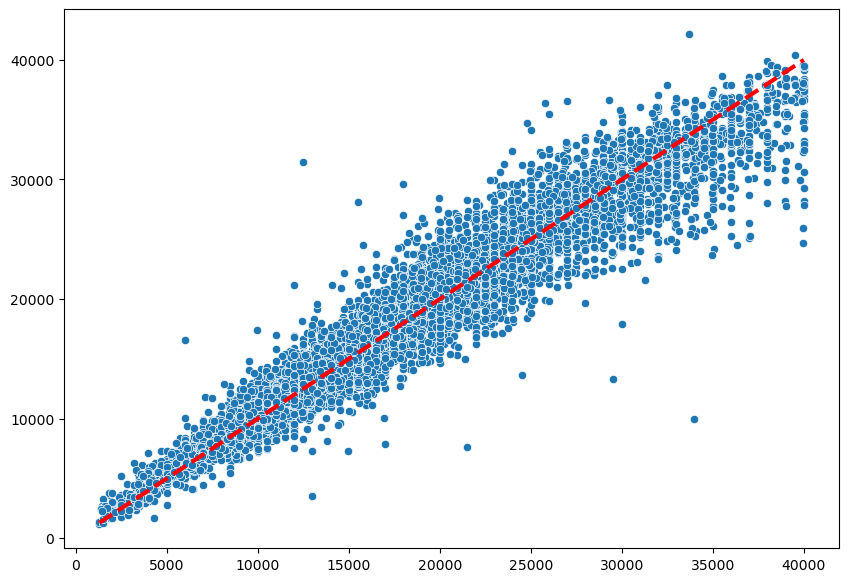

In [28]:
plt.figure(figsize=(10,7))

sns.scatterplot(x=y_test.values.ravel(),y=predictions_xgb) # created grafik model predictions 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3) 

## loaded my model in file

In [ ]:
# loaded my model in file
#with open("car_price_model.pkl", "wb") as f:
    #pickle.dump(xgb_model,f)
#with open("car_price_map.pkl", "wb") as f:
    #pickle.dump(model_price_map,f)     

## create description for embedding

In [29]:
def create_car_description(row):
    return(f"Used Car: {row['Brand']} {row['model']}. "
        f"Year: {int(row['year'])} ({int(row['age_car'])} years old). "
        f"Price: ${int(row['price'])}. "
        f"Transmission: {row['transmission']}. "
        f"Engine: {row['engineSize']} liters. "
        f"Mileage: {int(row['Mileage_km'])} km. "
        f"Fuel Consumption: {row['liters_per_100km']} L/100km. "
        f"Price Class Score: {row['Class avto']}.")

df_clear_iqr["text_for_embedding"] = df_clear_iqr.apply(create_car_description,axis=1)


## loaded model for embedding

In [30]:
chroma_client = chromadb.PersistentClient(path= r"C:\Users\Roman Shypka\chroma_db")
collection = chroma_client.get_collection(name="cars_collection")


model_transformer = SentenceTransformer("all-MiniLM-L6-v2")

sentences = df_clear_iqr["text_for_embedding"].tolist()

embeddings = model_transformer.encode(sentences,show_progress_bar=True)

Batches:   0%|          | 0/2118 [00:00<?, ?it/s]

In [32]:
cars_metadata=df_clear_iqr.to_dict(orient="records")

## creating a data separator

In [33]:
batch_size = 5000 

for i in range(0, len(sentences), batch_size):
    batch_sentences = sentences[i : i + batch_size]
    batch_embeddings = embeddings[i : i + batch_size].tolist()
    batch_ids = [str(idx) for idx in df_clear_iqr.index[i : i + batch_size]]
    batch_metadata= cars_metadata[i : i + batch_size]

    collection.upsert(
    embeddings=batch_embeddings,
    documents=batch_sentences,
    ids = batch_ids,
    metadatas= batch_metadata)
print(" Всі дані успішно збережені в базі!")
    

 Всі дані успішно збережені в базі!


In [34]:
collection.count()

67770

## creater query in natural language

In [35]:
my_query = "audi"

query_embedding = model_transformer.encode([my_query]).tolist()

result = collection.query(query_embeddings=query_embedding,n_results=500)
ids = [int(id) for id in result["ids"][0]]

# creating a filter for car uniqueness
found_car = df_clear_iqr.loc[ids]
unique_car = found_car.drop_duplicates(subset=["model"],keep = "first")
unique_car



,model,year,price,transmission,mileage,fuelType,engineSize,Mileage_km,liters_per_100km,Transmission_value,Brand,Brand_Code,age_car,Class avto,text_for_embedding
8140,A4,2017,16599,Automatic,36715,Diesel,2.0,59087,4.0,3,audi,0,9,19362.766517,Used Car: audi A4. Year: 2017 (9 years old). ...
7546,A3,2017,17390,Manual,7110,Petrol,0.0,11442,4.7,1,audi,0,9,17408.522032,Used Car: audi A3. Year: 2017 (9 years old). ...
2719,A6,2017,18082,Semi-Auto,25143,Diesel,2.0,40464,4.2,2,audi,0,9,21386.300423,Used Car: audi A6. Year: 2017 (9 years old). ...
4622,A1,2017,17962,Semi-Auto,19107,Petrol,1.4,30750,4.0,2,audi,0,9,14327.750557,Used Car: audi A1. Year: 2017 (9 years old). ...


## for future 

In [36]:
def build_chroma_filters(
    brands: Optional[List[str]]= None,
    max_price: Optional[int]=None,
    min_year: Optional[int]=None,
    max_mileage: Optional[int]=None,
    min_engine: Optional[float]=None,
    transmissions: Optional[str]=None
):
    filters_list = []
    
    if brands:
        filters_list.append({"Brand": {"$in": brands}})
    
    if max_price is not None:
        filters_list.append({"price":{"$lte": max_price}})
    
    if min_year is not None:
        filters_list.append({"year": {"$gte": min_year}})
    
    if max_mileage is not None:
        filters_list.append({"mileage": {"$lte": max_mileage}})
    
    if min_engine is not None:
        filters_list.append({"engineSize" : {"$gte": min_engine}})
    
    if transmissions is not None:
        filters_list.append({"transmission": {"$in": transmissions}})
    
    if len(filters_list)==0:
        return None 
    elif len(filters_list)==1:
        return filters_list[0]
    else:
        return {"$and": filters_list}
        
                                           
        